# Irish soil information system

<http://gis.teagasc.ie/soils/index.php>

In [1]:
import json
import os
from datetime import datetime, timezone
from zipfile import ZipFile
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
import requests
from matplotlib import ticker
from climag.download_data import download_data

In [2]:
print("Last updated:", datetime.now(tz=timezone.utc))

Last updated: 2022-10-26 13:53:02.018781+00:00


In [3]:
DATA_DIR = os.path.join("data", "soil")

In [4]:
os.makedirs(DATA_DIR, exist_ok=True)

In [5]:
# Ireland boundary
GPKG_BOUNDARY = os.path.join("data", "boundary", "boundaries.gpkg")
ie = gpd.read_file(GPKG_BOUNDARY, layer="NUTS_Ireland_ITM")

## Soil associations

In [44]:
# get full list of soil associations
URL = "http://gis.teagasc.ie/soils/services/get_all_associations.php"
try:
    r = requests.get(URL, stream=True, timeout=3000)
    print("Last downloaded:", datetime.now(tz=timezone.utc))
    soil_associations = pd.DataFrame(r.json())
    soil_associations.to_csv(
        os.path.join(DATA_DIR, "soil_associations.csv"), index=False
    )
except requests.exceptions.RequestException as err:
    print("Data download unsuccessful!", err)

Last downloaded: 2022-10-19 09:40:59.788987+00:00


In [6]:
soil_associations = pd.read_csv(
    os.path.join(DATA_DIR, "soil_associations.csv")
)

In [7]:
soil_associations.head()

,Association_Unit,Association_Symbol,Association_Name,Red_Value,Green_Value,Blue_Value
0,0300a,300a,Seafield,255,255,190
1,0360a,360a,Burren,255,255,0
2,0360c,360c,Crush,255,255,0
3,0410a,410a,Carrigvahanagh,153,89,3
4,0410b,410b,Bantry,153,89,3


## Soil series

In [46]:
# get full list of soil series
URL = "http://gis.teagasc.ie/soils/services/get_all_series.php"
try:
    r = requests.get(URL, stream=True, timeout=3000)
    print("Last downloaded:", datetime.now(tz=timezone.utc))
    soil_series = pd.DataFrame(r.json())
    soil_series.to_csv(os.path.join(DATA_DIR, "soil_series.csv"), index=False)
except requests.exceptions.RequestException as err:
    print("Data download unsuccessful!", err)

Last downloaded: 2022-10-19 09:42:04.409397+00:00


In [8]:
soil_series = pd.read_csv(os.path.join(DATA_DIR, "soil_series.csv"))

In [9]:
soil_series.head()

,National_Series_Id,National_Series,Red_Value,Green_Value,Blue_Value,Live
0,0110AE,Allen,112,107,102,LIVE
1,0110AEC,Allen Cutover,112,107,102,DEAD
2,0110AT,Aughty,112,107,102,LIVE
3,0110ATE,Aughty eroded phase,112,107,102,DEAD
4,0110ATH,Aughty shallow phase,112,107,102,DEAD


## Individual soil associations, full details

In [49]:
# individual soil associations, full details
soil_associations_full = {}
for s in list(soil_associations["Association_Unit"]):
    URL = f"http://gis.teagasc.ie/soils/get_associations.php?assoc_id={s}"
    try:
        r = requests.get(URL, stream=True, timeout=3000)
        print("Last downloaded:", datetime.now(tz=timezone.utc))
        soil_associations_full[s] = r.json()
    except requests.exceptions.RequestException as err:
        print("Data download unsuccessful!", err)

JSON_FILE_PATH = os.path.join(DATA_DIR, "soil_associations_full.json")
with open(JSON_FILE_PATH, "w", encoding="utf-8") as json_file:
    json.dump(soil_associations_full, json_file, ensure_ascii=False, indent=4)

Last downloaded: 2022-10-19 09:44:38.899065+00:00


In [14]:
soil_associations_full_df = pd.DataFrame(soil_associations_full).T

In [15]:
soil_associations_full_df.head()

,Association_Unit,Association_Symbol,Association_Name,Texture_Substrate_Type,SeriesArray,Red_Value,Green_Value,Blue_Value
0300a,0300a,300a,Seafield,Sandy stoneless drift,"[{'Rank': 1, 'National_Series_Id': '0300SE', '...",255,255,190
0360a,0360a,360a,Burren,Loamy over limestone bedrock,"[{'Rank': 1, 'National_Series_Id': '0360BU', '...",255,255,0
0360c,0360c,360c,Crush,Loamy over calcareous gravels,"[{'Rank': 1, 'National_Series_Id': '0360CS', '...",255,255,0
0410a,0410a,410a,Carrigvahanagh,Peat over lithoskeletal acid igneous rock,"[{'Rank': 1, 'National_Series_Id': '0410CV', '...",153,89,3
0410b,0410b,410b,Bantry,Peat over lithoskeletal sandstone and shale be...,"[{'Rank': 1, 'National_Series_Id': '0410BA', '...",153,89,3


### Soil associations and series

In [16]:
JSON_FILE_PATH = os.path.join(DATA_DIR, "soil_associations_full.json")

In [17]:
with open(JSON_FILE_PATH, encoding="utf-8") as json_file:
    soil_associations_full = json.load(json_file)
    json_file.close()

In [18]:
soil = {}
for key in soil_associations_full.keys():
    for i in range(len(soil_associations_full[key]["SeriesArray"])):
        val = soil_associations_full[key]["SeriesArray"][i][
            "National_Series_Id"
        ]
        soil[val] = key

In [19]:
soil_df = pd.DataFrame.from_dict(
    data=soil, orient="index", columns=["soil_association"]
)

In [20]:
soil_df.index.name = "soil_series"

In [21]:
soil_df.head()

,soil_association
soil_series,
0300SE,0300a
0900SN,0300a
0660BK,0300a
0860GB,0300a
0360BU,1150c


In [22]:
soil_df.to_csv(os.path.join(DATA_DIR, "soil_assoc_series.csv"))

In [23]:
soil_df.shape

(202, 1)

In [24]:
len(soil_df.index.unique())

202

In [25]:
len(soil_df["soil_association"].unique())

52

## Individual soil series, full details

In [50]:
# individual soil series, full details
soil_series_full = {}
for s in list(soil_series["National_Series_Id"]):
    URL = f"http://gis.teagasc.ie/soils/get_series.php?series_id={s}"
    try:
        r = requests.get(URL, stream=True, timeout=3000)
        print("Last downloaded:", datetime.now(tz=timezone.utc))
        soil_series_full[s] = r.json()
    except requests.exceptions.RequestException as err:
        print("Data download unsuccessful!", err)

JSON_FILE_PATH = os.path.join(DATA_DIR, "soil_series_full.json")
with open(JSON_FILE_PATH, "w", encoding="utf-8") as json_file:
    json.dump(soil_series_full, json_file, ensure_ascii=False, indent=4)

Last downloaded: 2022-10-19 09:46:28.461611+00:00


In [39]:
soil_series_full_df = pd.DataFrame(soil_series_full).T

In [40]:
soil_series_full_df.head()

,National_Series_Id,National_Series,Modern_Definition,Texture,Substrate_Type,Substrate_1,Substrate_2,Subgroup_Name,GreatGroup_Name,Red_Value,Green_Value,Blue_Value,PhotoArray,Live,Modern_Correlative_Code,Modern_Correlative_Name,RepProfileCount
0110AE,0110AE,Allen,Peat (Raised Bog {moss}),Peat,Peat,Peat,Raised Bog {moss},Natural Ombrotrophic Peat Soils,Ombrotrophic,112,107,102,[],LIVE,0110AE,Allen,1
0110AEC,0110AEC,Allen Cutover,"Peat (Raised Bog, undrained, hand-cut)",Peat,Peat,Peat,"Raised Bog, undrained, hand-cut",Natural Ombrotrophic Peat Soils,Ombrotrophic,112,107,102,[],DEAD,0180TB,Turbary,0
0110AT,0110AT,Aughty,Peat (Blanket Bog),Peat,Peat,Peat,Blanket Bog,Natural Ombrotrophic Peat Soils,Ombrotrophic,112,107,102,[],LIVE,0110AT,Aughty,1
0110ATE,0110ATE,Aughty eroded phase,Peat (Blanket Bog),Peat,Peat,Peat,Blanket Bog,Natural Ombrotrophic Peat Soils,Ombrotrophic,112,107,102,[],DEAD,0110AT,Aughty,0
0110ATH,0110ATH,Aughty shallow phase,Peat (Blanket Bog),Peat,Peat,Peat,Blanket Bog,Natural Ombrotrophic Peat Soils,Ombrotrophic,112,107,102,[],DEAD,0110AT,Aughty,0


In [41]:
soil_series_full_df.to_csv(
    os.path.join(DATA_DIR, "soil_series_full.csv"), index=False
)

## Individual soil series, full details plus representative information

In [51]:
# individual soil series, full details, plus representative site and horizon
# information
soil_series_full_rep = {}
for s in list(soil_series["National_Series_Id"]):
    URL = f"http://gis.teagasc.ie/soils/get_series_full.php?series_code={s}"
    try:
        r = requests.get(URL, stream=True, timeout=3000)
        print("Last downloaded:", datetime.now(tz=timezone.utc))
        soil_series_full_rep[s] = r.json()
    except requests.exceptions.RequestException as err:
        print("Data download unsuccessful!", err)

JSON_FILE_PATH = os.path.join(DATA_DIR, "soil_series_full_rep.json")
with open(JSON_FILE_PATH, "w", encoding="utf-8") as json_file:
    json.dump(soil_series_full_rep, json_file, ensure_ascii=False, indent=4)

Last downloaded: 2022-10-19 09:48:32.762323+00:00


In [42]:
soil_series_full_rep_df = pd.DataFrame(soil_series_full_rep).T

In [43]:
soil_series_full_rep_df.head()

,ReferenceNum,County,Elevation,SubGroup,SubGroupName,SeriesCode,SeriesName,Definition,WRB,Texture1,...,RockOutCrops,RockOutCropsText,RockOutCropsPercent,SurfaceStone,SurfaceStoneText,SurfaceStonePercent,Red_Value,Green_Value,Blue_Value,Horizons
0110AE,AFT_Legacy_291,None,None,110,Natural Ombrotrophic Peat Soils,0110AE,Allen,Peat (Raised Bog {moss}),Sapric Ombric Histosol (Dystric),None,...,None,None,None,None,None,None,112,107,102,"[{'Depth': 0, 'DepthTo': 9, 'HorizonNum': 1, '..."
0110AEC,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,[]
0110AT,AFT_Legacy_184,None,None,110,Natural Ombrotrophic Peat Soils,0110AT,Aughty,Peat (Blanket Bog),Sapric Ombric Histosol (Dystric),None,...,None,None,None,None,None,None,112,107,102,"[{'Depth': 0, 'DepthTo': 25, 'HorizonNum': 1, ..."
0110ATE,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,[]
0110ATH,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,[]


### Nitrogen totals

In [112]:
JSON_FILE_PATH = os.path.join(DATA_DIR, "soil_series_full_rep.json")

In [113]:
with open(JSON_FILE_PATH, encoding="utf-8") as json_file:
    soil_series_full_rep = json.load(json_file)
    json_file.close()

In [114]:
nitrogen = {}
for key in soil_series_full_rep.keys():
    if len(soil_series_full_rep[key]["Horizons"]) > 0:
        val = soil_series_full_rep[key]["Horizons"][0]["Total_Nitrogen"]
        if val is not None:
            nitrogen[key] = val

In [115]:
nitrogen_df = pd.DataFrame.from_dict(
    data=nitrogen, orient="index", columns=["total_nitrogen"]
)

In [116]:
nitrogen_df.index.name = "id"

In [117]:
nitrogen_df.head()

,total_nitrogen
id,
0110AE,1.2000
0110KM,1.7800
0170ATD,1.0533
0180ATC,1.2400
0180GM,0.6400


In [118]:
nitrogen_df.to_csv(os.path.join(DATA_DIR, "soil_nitrogen.csv"))

In [119]:
nitrogen_df.shape

(188, 1)

In [120]:
len(nitrogen_df.index.unique())

188

### Merge with soil associations/series

In [121]:
soil_nitrogen = pd.merge(
    nitrogen_df, soil_df, left_index=True, right_index=True
)

In [122]:
soil_nitrogen.reset_index(inplace=True)

In [123]:
soil_nitrogen.rename(columns={"index": "soil_series"}, inplace=True)

In [124]:
soil_nitrogen.shape

(177, 3)

In [125]:
soil_nitrogen.head()

,soil_series,total_nitrogen,soil_association
0,0110AE,1.2000,0760f
1,0110KM,1.7800,0800c
2,0170ATD,1.0533,0843f
3,0270BR,2.6233,1150c
4,0300BD,0.5120,1150c


In [138]:
# group by soil association and get the max percentage
soil_nitrogen_assoc = soil_nitrogen.groupby("soil_association").max(
    numeric_only=True
)

In [140]:
soil_nitrogen_assoc.shape

(50, 1)

## Soil map

In [43]:
# download data
URL = "http://gis.teagasc.ie/soils/downloads/INSM250k_ING_1b.zip"
download_data(server=URL, dl_dir=DATA_DIR)

Data successfully downloaded to data/soil 
Last downloaded: 2022-10-24 14:22:38.846802+00:00


In [44]:
os.listdir(DATA_DIR)

['INSM250k_ING_1b.zip',
 'soil_associations.csv',
 'soil_associations_full.json',
 'soil_nitrogen.csv',
 'soil_series.csv',
 'soil_series_full.csv',
 'soil_series_full.json',
 'soil_series_full_rep.json']

In [6]:
ZIP_FILE = os.path.join(DATA_DIR, "INSM250k_ING_1b.zip")

In [46]:
# list of files/folders in the ZIP archive
ZipFile(ZIP_FILE).namelist()

['INSM250k_ING.shx',
 'IrishSoilMap_Readme.txt',
 'INSM250k_ING.dbf',
 'INSM250k_ING.prj',
 'INSM250k_ING.sbn',
 'INSM250k_ING.sbx',
 'INSM250k_ING.shp',
 'INSM250k_ING.shp.xml',
 'INSM250k_ING.lyr']

In [7]:
soil_map = gpd.read_file(f"zip://{ZIP_FILE}!INSM250k_ING.shp")

In [28]:
soil_map.head()

,OBJECTID,Associatio,Associat_1,Associat_S,ha,Shape_Leng,Shape_Area,geometry
0,1,1xx,01_Bk,01xx,8.936193,1612.721788,89361.934889,"POLYGON ((74141.240 25254.740, 74092.700 25245..."
1,2,1xx,01_Bk,01xx,43.004953,4174.929755,430049.531439,"POLYGON ((78486.370 30618.920, 78508.940 30610..."
2,3,1xx,01_Bk,01xx,7.128532,2277.477286,71285.324866,"POLYGON ((84084.850 31526.640, 84063.110 31491..."
3,4,1xx,01_Bk,01xx,7.197259,1196.079972,71972.592919,"POLYGON ((91463.380 32014.920, 91460.570 31969..."
4,5,1xx,01_Bk,01xx,6.084085,2059.571505,60840.846554,"POLYGON ((120492.310 32806.090, 120498.080 327..."


In [8]:
soil_map.crs

<Derived Projected CRS: EPSG:29902>
Name: TM65 / Irish Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Ireland - onshore.
- bounds: (-10.56, 51.39, -5.93, 55.43)
Coordinate Operation:
- name: Irish Grid
- method: Transverse Mercator
Datum: TM65
- Ellipsoid: Airy Modified 1849
- Prime Meridian: Greenwich

In [30]:
soil_map.shape

(25140, 8)

In [35]:
# dissolve by association
soil_map = gpd.GeoDataFrame(soil_map).dissolve(by="Associatio")

In [37]:
soil_map.reset_index(inplace=True)

In [38]:
soil_map.head()

,Associatio,geometry,OBJECTID,Associat_1,Associat_S,ha,Shape_Leng,Shape_Area
0,0300a,"MULTIPOLYGON (((70058.763 294858.607, 70109.89...",6181,300a,0300a,0.875127,674.564393,8751.274482
1,0360a,"MULTIPOLYGON (((130644.750 177188.650, 130599....",6232,360a,0360a,13.465392,1680.146742,134653.922644
2,0360c,"MULTIPOLYGON (((132249.127 181075.206, 132231....",6319,360c,0360a,52.072508,5738.791389,520725.067535
3,0410a,"MULTIPOLYGON (((82144.178 58902.490, 82136.465...",6349,410a,0410a,0.874070,511.498903,8740.698503
4,0410b,"MULTIPOLYGON (((55562.762 42863.003, 55585.895...",6868,410b,0410b,10.026326,1828.094125,100263.259078


In [39]:
soil_map.shape

(69, 8)

In [47]:
# merge with soil associations
soil_map = pd.merge(
    soil_map,
    soil_associations,
    left_on="Associatio",
    right_on="Association_Unit",
)

In [48]:
soil_map.head()

,Associatio,geometry,OBJECTID,Associat_1,Associat_S,ha,Shape_Leng,Shape_Area,Association_Unit,Association_Symbol,Association_Name,Red_Value,Green_Value,Blue_Value
0,0300a,"MULTIPOLYGON (((70058.763 294858.607, 70109.89...",6181,300a,0300a,0.875127,674.564393,8751.274482,0300a,300a,Seafield,255,255,190
1,0360a,"MULTIPOLYGON (((130644.750 177188.650, 130599....",6232,360a,0360a,13.465392,1680.146742,134653.922644,0360a,360a,Burren,255,255,0
2,0360c,"MULTIPOLYGON (((132249.127 181075.206, 132231....",6319,360c,0360a,52.072508,5738.791389,520725.067535,0360c,360c,Crush,255,255,0
3,0410a,"MULTIPOLYGON (((82144.178 58902.490, 82136.465...",6349,410a,0410a,0.874070,511.498903,8740.698503,0410a,410a,Carrigvahanagh,153,89,3
4,0410b,"MULTIPOLYGON (((55562.762 42863.003, 55585.895...",6868,410b,0410b,10.026326,1828.094125,100263.259078,0410b,410b,Bantry,153,89,3


In [109]:
# define colours
# https://stackoverflow.com/a/26517762
for index, row in soil_map.iterrows():
    soil_map.loc[index, "hex"] = mcolors.to_hex(
        [
            row["Red_Value"] / 255,
            row["Green_Value"] / 255,
            row["Blue_Value"] / 255,
        ]
    )

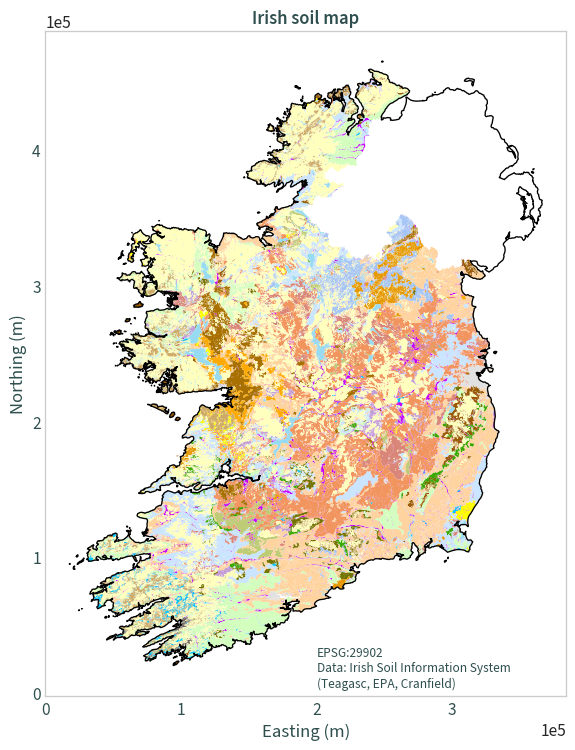

In [111]:
base = soil_map.plot(
    column="Associat_S",
    figsize=(9, 9),
    cmap=mcolors.ListedColormap(list(soil_map["hex"])),
)
ie.to_crs(soil_map.crs).boundary.plot(ax=base, color="black", linewidth=1)
base.xaxis.set_major_locator(ticker.MultipleLocator(1e5))
plt.ticklabel_format(style="scientific", scilimits=[-4, 4])
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.text(
    200000,
    4000,
    str(soil_map.crs).upper()
    + "\nData: Irish Soil Information System\n(Teagasc, EPA, Cranfield)",
)
plt.title("Irish soil map")
plt.show()

### Merge with soil data

In [141]:
soil_map_merged = pd.merge(
    soil_nitrogen_assoc,
    soil_map,
    left_on="soil_association",
    right_on="Associatio",
)

In [142]:
soil_map_merged.head()

,total_nitrogen,Associatio,geometry,OBJECTID,Associat_1,Associat_S,ha,Shape_Leng,Shape_Area,Association_Unit,Association_Symbol,Association_Name,Red_Value,Green_Value,Blue_Value,hex
0,0.4300,0300a,"MULTIPOLYGON (((70058.763 294858.607, 70109.89...",6181,300a,0300a,0.875127,674.564393,8751.274482,0300a,300a,Seafield,255,255,190,#ffffbe
1,0.3550,0360a,"MULTIPOLYGON (((130644.750 177188.650, 130599....",6232,360a,0360a,13.465392,1680.146742,134653.922644,0360a,360a,Burren,255,255,0,#ffff00
2,0.5840,0360c,"MULTIPOLYGON (((132249.127 181075.206, 132231....",6319,360c,0360a,52.072508,5738.791389,520725.067535,0360c,360c,Crush,255,255,0,#ffff00
3,2.0867,0410a,"MULTIPOLYGON (((82144.178 58902.490, 82136.465...",6349,410a,0410a,0.874070,511.498903,8740.698503,0410a,410a,Carrigvahanagh,153,89,3,#995903
4,1.8600,0410b,"MULTIPOLYGON (((55562.762 42863.003, 55585.895...",6868,410b,0410b,10.026326,1828.094125,100263.259078,0410b,410b,Bantry,153,89,3,#995903


In [143]:
soil_map_merged.shape

(50, 16)

In [145]:
soil_map_merged = gpd.GeoDataFrame(soil_map_merged)

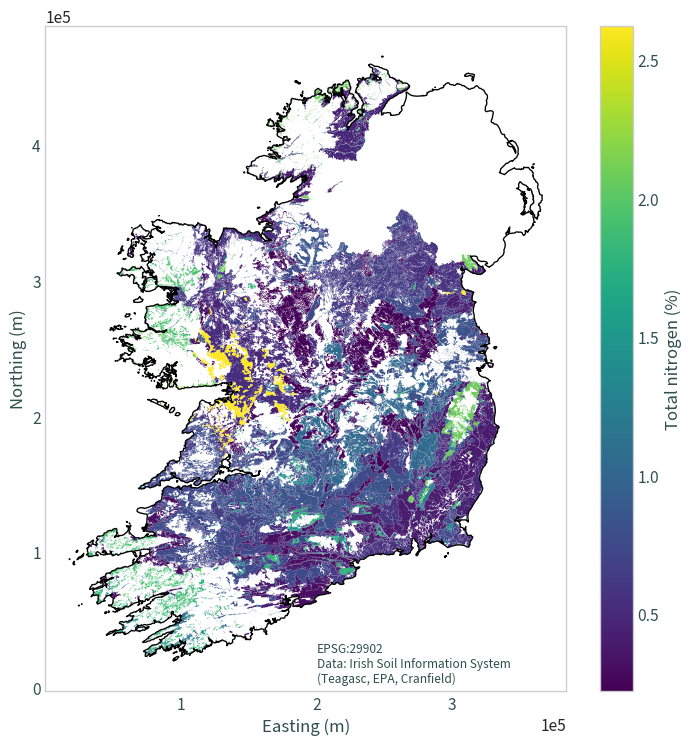

In [146]:
base = soil_map_merged.plot(
    column="total_nitrogen",
    cmap="viridis",
    legend=True,
    figsize=(9, 9),
    legend_kwds={"label": "Total nitrogen (%)"},
)
ie.to_crs(soil_map_merged.crs).boundary.plot(
    ax=base, color="black", linewidth=1
)
base.xaxis.set_major_locator(ticker.MultipleLocator(1e5))
plt.ticklabel_format(style="scientific", scilimits=[-4, 4])
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.text(
    200000,
    4000,
    str(soil_map_merged.crs).upper()
    + "\nData: Irish Soil Information System\n(Teagasc, EPA, Cranfield)",
)
# plt.title("Irish soil map")
plt.show()

In [148]:
soil_map_merged.to_file(
    os.path.join(DATA_DIR, "soil.gpkg"), layer="soil_nitrogen_assoc_max"
)